# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [35]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [36]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

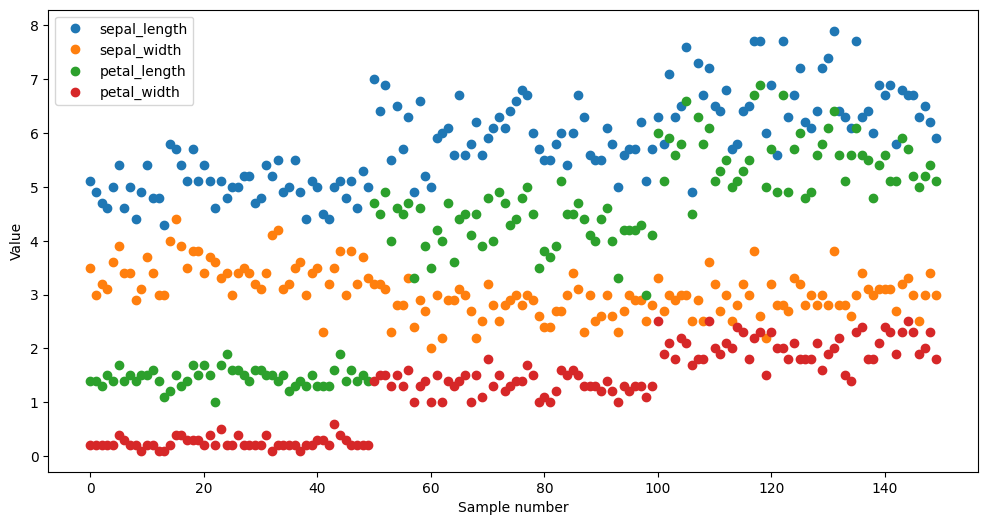

In [37]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [38]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [39]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
def createData(batchsize = 1):
   train_loader = DataLoader(train_data, batch_size = batchsize, shuffle=True, drop_last=True)
   test_loader  = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) # how big should these batches be??

   return train_loader,test_loader


In [40]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape, y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])
torch.Size([32, 4]) torch.Size([32])


# Construct the model and training plans

In [41]:
# a function that creates the ANN model
def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64, 64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64, 3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.001)

  return ANNiris, lossfun, optimizer

In [54]:
# train the model

# global parameter
numepochs = 500

def trainTheModel(train_loader, test_loader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # ANNiris.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())
      batchLoss.append(loss.item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    losses.append(np.mean(batchLoss))

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # ANNiris.eval()
    with torch.no_grad():
      predlabels = torch.argmax(ANNiris(X), axis = 1)

    testAcc.append(100 * torch.mean((predlabels == y).float()).item())

  # function output
  return trainAcc, testAcc, losses


# Test it out

In [55]:
batch_sizes = [2**n for n in range(1, 6)]
allaccuracies_train = np.zeros((numepochs, len(batch_sizes)))
allaccuracies_test = np.zeros((numepochs, len(batch_sizes)))

for index, batchsize in enumerate(batch_sizes):
   # create data
   train_loader, test_loader = createData(batchsize)

   # create a model
   ANNiris, lossfun, optimizer = createANewModel()

   # train the model
   trainAcc, testAcc, losses = trainTheModel(train_loader, test_loader)

   allaccuracies_train[:, index] = trainAcc
   allaccuracies_test[:, index] = testAcc


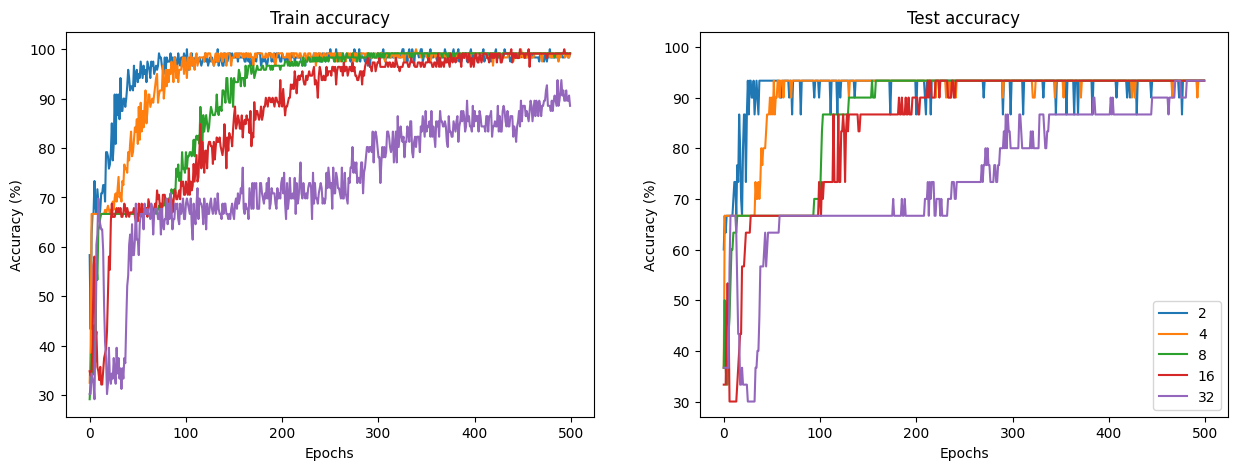

In [57]:
# plot the results
fig,ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(allaccuracies_train)
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train accuracy')

ax[1].plot(allaccuracies_test)
ax[1].set_title('Test accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(batch_sizes)
ax[1].set_ylim([27, 103])

plt.show()